In [1]:
%matplotlib inline
%config IPCompleter.greedy=True
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
import random
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
import sklearn.metrics as metrics
from sklearn import preprocessing
import matplotlib.image as mpimg
from skimage.io import imread, imsave, imshow
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage

import tensorflow
import tensorflow.keras
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
# from tensorflow.keras.utils import np_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import re

# K.set_image_dim_ordering('tf')
plt.rcParams['image.cmap'] = 'gray'
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

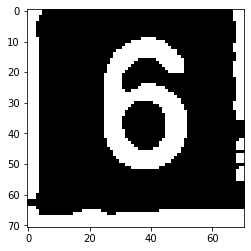

In [9]:
image = cv2.imread('data/image_2367_6.png')

def preprocess_img(img):
    width = img.shape[0]
    height = img.shape[1]

    center = (width/2, height/2)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 3)
    tresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    result = cv2.bitwise_not(tresh, tresh)

    # contours, _ = cv2.findContours(result.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # # Remove small noise
    kernel = np.ones((3, 3), np.uint8) 
    result = cv2.erode(result, kernel)
    result = cv2.dilate(result, kernel)

    # dist = []

    # closest_pnt = []
    # for contour in contours:
    #     points = []
    #     for point in contour:
    #         xa, ya = point[0]
    #         xb, yb = center
    #         distance = math.sqrt((xb - xa)**2 + (yb - ya)**2)
    #         points.append(distance)
    #     closest_pnt.append(min(points))

    # for contour in contours:
    #     points = []
    #     for point in contour:
    #         xa, ya = point[0]
    #         xb, yb = center
    #         distance = math.sqrt((xb - xa)**2 + (yb - ya)**2)
    #         points.append(distance)

    #     if min(points) > min(closest_pnt):
    #         cv2.fillPoly(result, pts=[contour], color=(0,0,0))
    #         continue
    
    return result

plt.imshow(preprocess_img(image))

In [10]:
image_size = 100


images = []
labels = []
names = []
# read infected train_images
path = 'data/'
valid_images = [".jpg",".gif",".png"]

for f in tqdm(os.listdir(path)):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    names.append(f)
    # im = cv2.imread(os.path.join(path,f))
    im = preprocess_img(cv2.imread(os.path.join(path,f)))
    im = transform.resize(im,(image_size,image_size), mode='constant', anti_aliasing=True)
    images.append(im)
    s = f.split('_')[2].split('.')[0]
    labels.append(int(s))

100%|██████████| 8526/8526 [00:19<00:00, 431.30it/s]


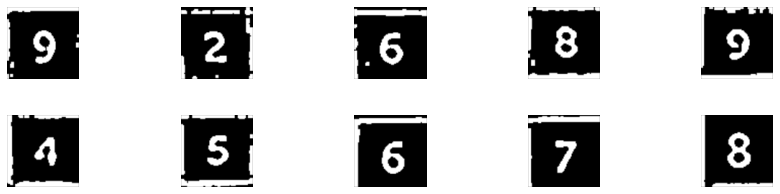

In [11]:
# -----------------------
# --- PLOTTING IMAGES ---
# -----------------------

def plot_images(list_images, rows, columns, num_images):
    for index, val in enumerate(list_images[:num_images]):
        plt.subplot(rows,columns,index+1)
        plt.axis('off')
        plt.subplots_adjust(bottom=1, right=2, top=2, wspace=0.5, hspace=0.5)
        plt.imshow(val)

plot_images(images[600:], rows=3, columns=5, num_images=10)

image_6409_3.png


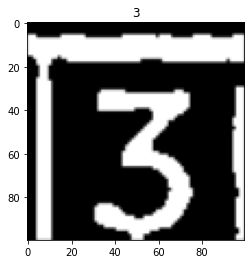

In [12]:
index = 6000
plt.title(labels[index])
plt.imshow(images[index])
print(names[index])

<BarContainer object of 10 artists>

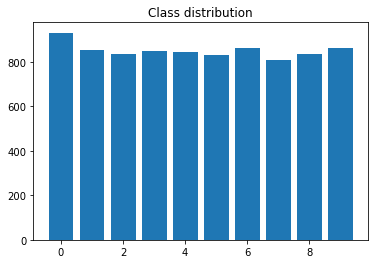

In [13]:
unique, counts = np.unique(np.array(labels), return_counts=True)
bar_data = list(zip(unique, counts))
plt.title('Class distribution')
plt.bar(*zip(*bar_data))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=20)

X_train, X_test, y_train = np.asarray(X_train, dtype=np.float32), np.asarray(X_test, dtype=np.float32), np.asarray(y_train, dtype=np.float32)

y_train = to_categorical(y_train)

In [15]:
# ----------------------
# --- NEURAL NETWORK ---
# ----------------------

# Early stopping callback
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=2, patience=1)
model_checkpoint = ModelCheckpoint('models/number_classifier_v1.0.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto')

# Weight Balancing
# class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

batch_size = 100 # 
epochs = 20 # 
num_classes = 10
img_rows, img_cols = 100, 100
input_shape = (img_rows, img_cols, 1)

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape)) 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Trainen van het CNN
history = model.fit(X_train.reshape(len(X_train), 100, 100, 1), y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1, callbacks=[model_checkpoint]) #  callbacks=[earlystop_callback]

Train on 5456 samples, validate on 1364 samples
Epoch 1/20
5456/5456 [==============================] - 11s 2ms/sample - loss: 0.7806 - accuracy: 0.7608 - val_loss: 0.1613 - val_accuracy: 0.9641
Epoch 2/20
5456/5456 [==============================] - 9s 2ms/sample - loss: 0.0930 - accuracy: 0.9756 - val_loss: 0.0686 - val_accuracy: 0.9861
Epoch 3/20
5456/5456 [==============================] - 9s 2ms/sample - loss: 0.0376 - accuracy: 0.9914 - val_loss: 0.0554 - val_accuracy: 0.9890
Epoch 4/20
5456/5456 [==============================] - 9s 2ms/sample - loss: 0.0231 - accuracy: 0.9947 - val_loss: 0.0430 - val_accuracy: 0.9919
Epoch 5/20
5456/5456 [==============================] - 9s 2ms/sample - loss: 0.0182 - accuracy: 0.9949 - val_loss: 0.0512 - val_accuracy: 0.9897
Epoch 6/20
5456/5456 [==============================] - 9s 2ms/sample - loss: 0.0170 - accuracy: 0.9960 - val_loss: 0.0388 - val_accuracy: 0.9934
Epoch 7/20
5456/5456 [==============================] - 9s 2ms/sample - los

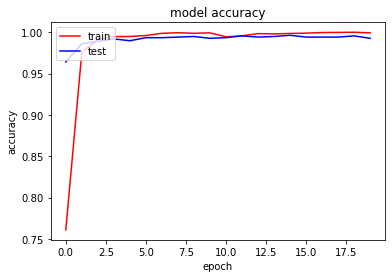

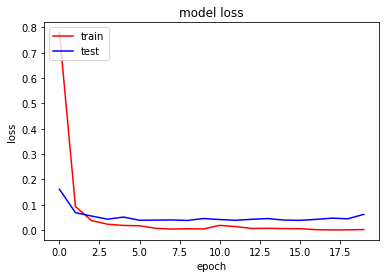

In [16]:
# -------------------------------
# --- ACCURRACY / LOSS CURVES ---
# -------------------------------

# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
model = load_model('models/number_classifier_v1.0.hdf5')

In [18]:
pred = model.predict_classes(X_test.reshape(len(X_test), 100, 100, 1))
print(pred[0:10])

[3 6 7 5 7 5 9 6 2 3]


In [19]:
print(classification_report(y_test, pred))

precision    recall  f1-score   support

           0       1.00      0.98      0.99       194
           1       0.99      0.98      0.98       157
           2       0.98      0.99      0.99       173
           3       0.98      1.00      0.99       171
           4       1.00      0.99      0.99       170
           5       1.00      1.00      1.00       139
           6       1.00      1.00      1.00       163
           7       0.99      0.99      0.99       166
           8       0.99      0.99      0.99       188
           9       0.99      0.99      0.99       185

    accuracy                           0.99      1706
   macro avg       0.99      0.99      0.99      1706
weighted avg       0.99      0.99      0.99      1706



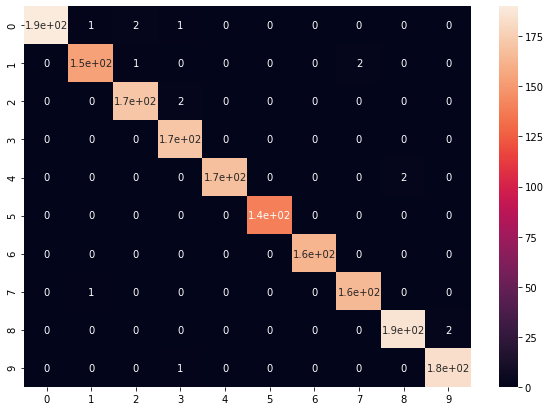

In [20]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def plot_cf(cf):
    df_cm = pd.DataFrame(cf, index = [i for i in "0123456789"],
                    columns = [i for i in "0123456789"])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

cf = confusion_matrix(y_test, pred)
plot_cf(cf)

actual value: 7
Index: 410


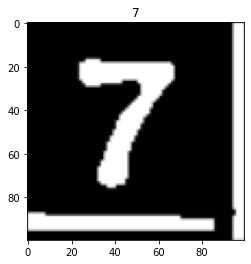

In [35]:
import random
index = random.randint(0, len(X_test)-1) 
plt.title(pred[index])
plt.imshow(X_test[index])
print('actual value: {}'.format(y_test[index]))
print('Index: {}'.format(index))